## Tree Species Classification in Aerial Imagery of Wasatch Mountains Using Convolutional Neural Networks

Northern Utah has a delicate natural environment, small changes in which could result in substantial consequences for Utah residents and native species, as well as perennial migrating species. Forest fires could contribute to hazardous air quality and endanger neighborhoods and animals. Mountain forests influence local weather and serve as protection from premature snowpack melt-off. An endangered canopy could, therefore, have severe consequences on local water supply throughout the year. The canopy also has a symbiotic relationship with many undergrowth plants, which serve as food and shelter for many animal species. Plant roots also help prevent mudslides. Different species face different challenges. Some burn easily. Some are invasive, others vulnerable. Determining the range of species over an area and tracking change over time can be useful in forest management and in monitoring local effects of climate change, allowing us to find solutions to problematic changes before critical effects occur.

To accomplish the task of segmenting imagery into labels for different species, a deep learning approach using 3-dimensional (3D) convolutional neural networks (CNN) was used. Partial ground truth images were created to evaluate model performance and segment every image in the collected dataset. These images were labeled manually as a part of this project, and accounted for a large portion of the effort. Labeling was accomplished using the open source image editor GIMP. This process was assisted using other imagery of the same area from other periods of the year (autumn and winter), to help differentiate between species. 3 of the images were used for training, while the remaining 3 were used only for testing.

The Tensorflow and Keras libraries were used to develop, run, and test CNN models. EarthPy, SciPy, Matplotlib, and OpenCV were used to read, write, and display image data. Pandas and NumPy were used for working with the data. Scikitlearn was used for creating train-test splits and evaluating model performance. The Seaborn package was used for generating heatmaps of the results.

The end goal of this project is to perform segmentation on aerial imagery that covers the entire Wasatch Range.

In [1]:
# Import libraries and call functions

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
from scipy.io import loadmat, savemat
import earthpy.plot as ep
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv3D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime
import pandas as pd
import seaborn as sns

### Image 1

The image that was labeled, used for training, and subsequently segmented was downloaded from the United States Geological Survey (USGS) EarthExplorer portal: https://earthexplorer.usgs.gov/. The specific source dataset is aerial imagery, taken between June 27 and August 20, 2016, of the Wasatch Mountains in Northern Utah, as part of the National Agricultural Imagery Program (NAIP). This aerial imagery has a resolution of 1 meter, meaning every pixel in each image represents a square area on the ground with each side measuring 1 meter. Images contain 4 bands: a red channel, blue channel, green channel, and near-infrared (NIR) channel.

Landsat and Sentinel satellite imagery was initially considered for this project. Although the satellite imagery contains many more bands--Sentinel-2 has 13--the resolutions are much lower, with a best resolution of 10 meters. While this may be sufficient for agricultural purposes, coverage of the natural forests of the Wasatch Mountains is random, with many forests mixing several species of trees within a few feet of each other.

The image is read in and displayed below.

In [ ]:
im1 = plt.imread('im1\m_4011144_se_12_1_20160802.tif')

# Move band channel to first dimension for compatibility with EarthPy
im1 = np.moveaxis(im1, 2, 0)

ep.plot_rgb(
    im1,
    rgb=(0, 1, 2),
    figsize=(12, 16),
    title="RGB Composite Image of Area to Be Segmented",
)

plt.show()

The four bands in this image are displayed below.

In [ ]:
ep.plot_bands(im1, 
              cmap = 'gist_earth', 
              figsize = (15, 20), 
              cols = 2, 
              cbar = False, 
              title=['Red (R)','Green (G)','Blue (B)','Near-Infrared (NIR)'])
plt.show()

Wasatch Mountain forests can be primarily divided into four parts: The Bigtooth Maple, Quaking Aspen, Gambel Oak, and several species of evergreen trees. The evergreens consist almost entirely of fir, juniper, and spruce trees. As these would be difficult to differentiate for labeling, all evergreens were labeled as Conifer. There are many other species of tree in the Wasatch Mountains that were excluded from labeling. They were consequently mislabeled as one of the other 4 tree species in the final prediction map; however, this is not a big issue as other tree species combined likely cover well below 1% of the mountain range map area, mostly along the the edges of streams and rivers.

Grasslands and shrub areas were labeled as other, and areas of litte to no vegetation were labeled as none (called non in the code). In total, there are six labels in the training data:

1. Maple
2. Aspen
3. Oak
4. Conifer
5. Other
6. None

As mentioned previously, other NAIP images taken from other periods of the year were used to assist in labeling the ground truth image. These images were not used in training, only for assistance in differentiating species in the image above. The autumn image below was especially helpful in accurately labeling the imagery.

In [ ]:
autumn_im = plt.imread('im1/autumn_im.tif')

# Move band channel to first dimension for compatibility with EarthPy
autumn_im = np.moveaxis(autumn_im, 2, 0)

ep.plot_rgb(
    autumn_im,
    rgb=(0, 1, 2),
    figsize=(12, 16),
)

plt.show()

We can take a closer look at the bottom right corner of this image:

In [ ]:
ep.plot_rgb(
    autumn_im[:,9500:11800,7200:9429],
    rgb=(0, 1, 2),
    figsize=(12, 16),
)

plt.show()

As it is still early autumn in the picture, most trees are still green but many are beginning to change. In the above image we can clearly see the aspens on the left, turning yellow. The maples are seen turning pink on the right. The conifers remain a deep green at the top, but are intermixed with aspens beginning to change that would have been hard to identify in the summer image. There is a meadow at the bottom left with other vegetation, a few clearings on the right with little to no vegetation, and the oaks located in the middle, mostly still green, but starting to turn brown in some places.

This image helped greatly in labeling data when combined with the original image below, where it was difficult to separate the aspens from the conifers at the top of the image, and the maples from the oaks.

In [ ]:
ep.plot_rgb(
    im1[:,5800:7250,4480:5800],
    rgb=(0, 1, 2),
    figsize=(12, 16),
)

plt.show()

The masks created in GIMP for each species contain pixels with values of 1 or very near 1 and 0 or very near 0. These pixels are forced to exactly 1 or 0 depending on their values, and inverted, as labeled areas have a value of 0 in the input images, and need to be 1 for the task.

For ease of labeling, the forests with oak trees and other labeled for this task contained many patches with little to no vegetation that should be classified as None. To remove the labels over these patches, an image employing the normalized difference vegetation index (NDVI) for the training image was created. NDVI is calculated using Red and NIR channels and outputs high values for areas with dense vegetation and low values for areas with little to none. This NDVI image was used to remove labels in Oak and Other images where the NDVI was low.

The ground truth image is create by the function below.

In [7]:
# Read in labels masks and create and save ground truth data to .mat, optional plotting of masks

def create_gt_im (im, i, plot = False):
    # Create NDVI Image
    float_im = im.astype('float32')
    red = float_im[0]
    nir = float_im[3]
    ndvi_im = (nir-red)/(nir+red)
    ndvi_mask = np.where(ndvi_im > 0, 1, 0)
    cv2.imwrite("im{}/ndvi{}.jpg".format(i,i), ndvi_mask*255)

    # Mask for low NDVI portions
    low_ndvi = cv2.imread('im{}/ndvi{}.jpg'.format(i,i), cv2.IMREAD_GRAYSCALE)
    low_ndvi = cv2.normalize(low_ndvi, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    low_ndvi = np.where(low_ndvi > 0.5, 1, 0)
    low_ndvi = 1 - low_ndvi

    # Mask for maples
    maple = cv2.imread('im{}/maple{}.jpg'.format(i,i), cv2.IMREAD_GRAYSCALE)
    maple = cv2.normalize(maple, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    maple = np.where(maple > 0.5, 1, 0)
    maple = 1 - maple

    # Mask for aspens
    aspen = cv2.imread('im{}/aspen{}.jpg'.format(i,i), cv2.IMREAD_GRAYSCALE)
    aspen = cv2.normalize(aspen, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    aspen = np.where(aspen > 0.5, 1, 0)
    aspen = 1 - aspen

    # Mask for oaks
    oak = cv2.imread('im{}/oak{}.jpg'.format(i,i), cv2.IMREAD_GRAYSCALE)
    oak = cv2.normalize(oak, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    oak = np.where(oak > 0.5, 1, 0)
    oak = 1 - oak
    # Removing labels from low NDVI areas
    oak = np.where(oak == 1, oak - low_ndvi, 0)

    # Mask for conifers
    conifer = cv2.imread('im{}/conif{}.jpg'.format(i,i), cv2.IMREAD_GRAYSCALE)
    conifer = cv2.normalize(conifer, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    conifer = np.where(conifer > 0.5, 1, 0)
    conifer = 1 - conifer

    # Mask for other
    other = cv2.imread('im{}/other{}.jpg'.format(i,i), cv2.IMREAD_GRAYSCALE)
    other = cv2.normalize(other, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    other = np.where(other > 0.5, 1, 0)
    other = 1 - other
    # Removing labels from low NDVI areas
    other = np.where(other == 1, other - low_ndvi, 0)

    # Mask of areas with low to no vegetation
    non = cv2.imread('im{}/none{}.jpg'.format(i,i), cv2.IMREAD_GRAYSCALE)
    non = cv2.normalize(non, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    non = np.where(non > 0.5, 1, 0)
    non = 1 - non

    gt_im = maple + 2 * aspen + 3 * oak + 4 * conifer + 5 * other + 6 * non

    gt_im = gt_im.astype('uint8')

    savemat('im{}/gt{}.mat'.format(i,i), {'gt': gt_im})

    if plot == True:
        ep.plot_bands(np.stack([low_ndvi, maple, aspen, oak, conifer, other, non]), 
                      cmap = 'gray', 
                      figsize = (15, 20), 
                      cols = 3, 
                      cbar = False, 
                      title=['Low NDVI', 'Maple', 'Aspen', 'Oak', 'Conifer', 'Other', 'None'])
        plt.show()

    return gt_im

Each mask image is shown below. The NDVI image was only used to remove low NDVI areas from the Oak mask.

In [ ]:
y_data = create_gt_im(im1, "1", plot = True)

In [9]:
def seg_viz(y_data, label='Image', size=(12, 16)):
    gt = np.zeros((y_data.shape[0], y_data.shape[1], 3), dtype = 'uint8')
    gt[y_data == 1] = [255,0,0] # Red for Maple
    gt[y_data == 2] = [255,255,0] # Yellow for Aspen
    gt[y_data == 3] = [255,165,0] # Orange for Oak
    gt[y_data == 4] = [0,100,0] # Dark green for Conifer
    gt[y_data == 5] = [50,205,50] # Lime green for Other
    gt[y_data == 6] = [245,245,220] # Beige for None

    gt = np.moveaxis(gt, 2, 0)

    ep.plot_rgb(
        gt,
        rgb=(0, 1, 2),
        figsize=size,
        title=label,
    )

    plt.show()

    rp = mpatches.Patch(color='red', label='Maple')
    yp = mpatches.Patch(color='yellow', label='Aspen')
    op = mpatches.Patch(color='orange', label='Oak')
    dgp = mpatches.Patch(color='darkgreen', label='Conifer')
    lgp = mpatches.Patch(color='limegreen', label='Other')
    bp = mpatches.Patch(color='beige', label='None')

    plt.figure(figsize=(1,1))
    plt.legend(handles=[rp, yp, op, dgp, lgp, bp])
    plt.gca().set_axis_off()
    plt.show()

The ground truth image can be seen below. This isn't complete ground truth, as most areas with the species of interest were not labeled, but enough was labeled for training to accomplish the goal of creating a full prediction image. Mostly, large uninterrupted groves of a single species were chosen for labeling, as this was easiest to do accurately, but much smaller segments, and in some cases individual trees, were also labeled.

In [ ]:
seg_viz(y_data, "Ground Truth (Partial)")

Now the data to be used for training and test purposes is created.

In [11]:
# Move band channel to 3rd dimension and read in ground truth image
X_data = np.moveaxis(im1, 0, -1)
y_data = loadmat('im1/gt1.mat')['gt']

To condense the data for better run speed and memory performance, columns and rows with no nonzero label values are removed.

In [12]:
def drop_zero_rc(X, y):
    X = X[:,~np.all(y == 0, axis = 0)]
    y = y[:,~np.all(y == 0, axis = 0)]
    X = X[~np.all(y == 0, axis = 1)]
    y = y[~np.all(y == 0, axis = 1)]
    return X, y

In [13]:
X_data, y_data = drop_zero_rc(X_data, y_data)

In order to apply 3D convolution for the CNN model, a function to create cube patches from the data was used. This function was repurposed from code in Syam Kakarla's Github folder: https://gist.github.com/syamkakarla98/c76733c48d739a17c1d638450be06f4e, though I later found nearly identical code in a research study conducted around the same time: https://ieeexplore.ieee.org/document/9307220, code here: https://github.com/mahmad00/A-Fast-and-Compact-3-D-CNN-for-HSIC/blob/master/A_Fast_3D_CNN_for_HSIC_v2.ipynb. I made slight modifications for this project.

In [14]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = False):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]), dtype = 'uint8')
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]), dtype = 'uint8')
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

windowSize = 7
K = X_data.shape[2]

In [15]:
# Create 3D Patches
sX1, sy1 = createImageCubes(X_data, y_data, windowSize=windowSize, removeZeroLabels = True)
print(f'Patch size: {sX1.shape}, Labels size: {sy1.shape}')

Patch size: (1223605, 7, 7, 4), Labels size: (1223605,)


Before training a model, the end goal needs to be considered. This model will be used to segment all 144 images of the Wasatch Range in our dataset; however, these images cover a huge area and a period of 2.5 months. Vegetation will look different in early summer than in late summer. Also, images will be taken at different times of the day, though normally close to noon, and some images will see the vegetation at different angles. To account for this and avoid overfitting to the above image, there are two tasks that should improve model performance.

The first task is to perform some data augmentation on the original image. Some transformations to the original image are performed and cube patches of the transformed images are added to the training data. The image is flipped horizontally first, then vertically.

In [16]:
# Horizontal Flip
X_data = np.flip(X_data,1)
y_data = np.flip(y_data,1)
sX2, sy2 = createImageCubes(X_data, y_data, windowSize=windowSize, removeZeroLabels = True)

In [17]:
# Vertical Flip
X_data = np.flip(X_data,0)
y_data = np.flip(y_data,0)
sX3, sy3 = createImageCubes(X_data, y_data, windowSize=windowSize, removeZeroLabels = True)

For the second task, two other images were chosen for training. The image above was taken in August in a central part of the range. The first additional image was taken in June in the northern part of the range. The second was taken in July in the southern part. The data for these images is displayed below.

### Image 2

In [ ]:
im2 = plt.imread('im2\m_4011102_nw_12_1_20160627.tif')

# Move band channel to first dimension for compatibility with EarthPy
im2 = np.moveaxis(im2, 2, 0)

ep.plot_rgb(
    im2,
    rgb=(0, 1, 2),
    figsize=(12, 16),
    title="RGB Composite Image of Area to Be Segmented",
)

plt.show()

In [ ]:
y_data = create_gt_im(im2, '2')
seg_viz(y_data, "Ground Truth (Partial)")

In [20]:
# Move band channel to 3rd dimension and read in ground truth image
X_data = np.moveaxis(im2, 0, -1)
y_data = loadmat('im2/gt2.mat')['gt']

In [21]:
X_data, y_data = drop_zero_rc(X_data, y_data)

The 3D patch data is now created, and 0 rows dropped.

In [22]:
# Create 3D Patches
sX4, sy4 = createImageCubes(X_data, y_data, windowSize=windowSize, removeZeroLabels = True)
print(f'Patch size: {sX4.shape}, Labels size: {sy4.shape}')

Patch size: (447872, 7, 7, 4), Labels size: (447872,)


Transformed images are also added.

In [23]:
# Horizontal Flip
X_data = np.flip(X_data,1)
y_data = np.flip(y_data,1)
sX5, sy5 = createImageCubes(X_data, y_data, windowSize=windowSize, removeZeroLabels = True)

In [24]:
# Vertical Flip
X_data = np.flip(X_data,0)
y_data = np.flip(y_data,0)
sX6, sy6 = createImageCubes(X_data, y_data, windowSize=windowSize, removeZeroLabels = True)

### Image 3

In [ ]:
im3 = plt.imread('im3/m_3911104_nw_12_1_20160711.tif')

# Move band channel to first dimension for compatibility with EarthPy
im3 = np.moveaxis(im3, 2, 0)

ep.plot_rgb(
    im3,
    rgb=(0, 1, 2),
    figsize=(12, 16),
    title="RGB Composite Image of Area to Be Segmented",
)

plt.show()

In [ ]:
y_data = create_gt_im(im3, '3')
seg_viz(y_data, "Ground Truth (Partial)")

In [27]:
# Move band channel to 3rd dimension and read in ground truth image
X_data = np.moveaxis(im3, 0, -1)
y_data = loadmat('im3/gt3.mat')['gt']

In [28]:
X_data, y_data = drop_zero_rc(X_data, y_data)

In [29]:
# Create 3D Patches
sX7, sy7 = createImageCubes(X_data, y_data, windowSize=windowSize, removeZeroLabels = True)
print(f'Patch size: {sX7.shape}, Labels size: {sy7.shape}')

Patch size: (304703, 7, 7, 4), Labels size: (304703,)


In [30]:
# Horizontal Flip
X_data = np.flip(X_data,1)
y_data = np.flip(y_data,1)
sX8, sy8 = createImageCubes(X_data, y_data, windowSize=windowSize, removeZeroLabels = True)

In [31]:
# Vertical Flip
X_data = np.flip(X_data,0)
y_data = np.flip(y_data,0)
sX9, sy9 = createImageCubes(X_data, y_data, windowSize=windowSize, removeZeroLabels = True)

### 3D CNN Model

Now the sets of data are combined.

In [32]:
sX = np.concatenate((sX1, sX2, sX3, sX4, sX5, sX6, sX7, sX8, sX9), axis=0)
sy = np.concatenate((sy1, sy2, sy3, sy4, sy5, sy6, sy7, sy8, sy9), axis=0)
[sX.shape, sy.shape]

[(5928540, 7, 7, 4), (5928540,)]

Finally, the data is ready for a train test split and CNN model.

In [33]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(sX, sy, test_size=0.3, random_state=42, stratify=sy)

In [34]:
X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)

# One Hot Encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'Train: {X_train.shape}\nTest: {X_test.shape}\nTrain Labels: {y_train.shape}\nTest Labels: {y_test.shape}')

Train: (4149978, 7, 7, 4, 1)
Test: (1778562, 7, 7, 4, 1)
Train Labels: (4149978, 6)
Test Labels: (1778562, 6)


In [35]:
output_units = y_train.shape[1]

input_layer = Input((windowSize, windowSize, K, 1))

x = Conv3D(filters=16, kernel_size=(3, 3, 2), activation='relu')(input_layer)
x = Conv3D(filters=32, kernel_size=(3, 3, 2), activation='relu')(x)
x = Conv3D(filters=64, kernel_size=(2, 2, 2), activation='relu')(x)
x = Conv3D(filters=64, kernel_size=(2, 2, 1), activation='relu')(x)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(units=output_units, activation='softmax')(x)

model = Model(name = 'Wasatch_Model' , inputs=input_layer, outputs=output_layer)

model.summary()

Model: "Wasatch_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 4, 1)]      0         
                                                                 
 conv3d (Conv3D)             (None, 5, 5, 3, 16)       304       
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 3, 2, 32)       9248      
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 2, 1, 64)       16448     
                                                                 
 conv3d_3 (Conv3D)           (None, 1, 1, 1, 64)       16448     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 256)             

In [36]:
# Compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Callbacks
logdir = "Wasatch/logs/" +model.name+'_'+datetime.now().strftime("%d%m%Y%H%M%S")

tensorboard_callback = TensorBoard(log_dir=logdir)

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 1,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Wasatch_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model.fit(x=X_train, y=y_train, 
                    batch_size=1024, epochs=50, 
                    validation_data=(X_test, y_test), callbacks = [tensorboard_callback, es, checkpoint])

Epoch 1/50
4053/4053 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.8760
Epoch 1: val_loss improved from inf to 0.20813, saving model to Wasatch_Model.h5
4053/4053 [==============================] - 214s 52ms/step - loss: 0.3192 - accuracy: 0.8760 - val_loss: 0.2081 - val_accuracy: 0.9208
Epoch 2/50
4052/4053 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9233
Epoch 2: val_loss improved from 0.20813 to 0.17339, saving model to Wasatch_Model.h5
4053/4053 [==============================] - 204s 50ms/step - loss: 0.2028 - accuracy: 0.9233 - val_loss: 0.1734 - val_accuracy: 0.9335
Epoch 3/50
4053/4053 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9348
Epoch 3: val_loss improved from 0.17339 to 0.16530, saving model to Wasatch_Model.h5
4053/4053 [==============================] - 207s 51ms/step - loss: 0.1741 - accuracy: 0.9348 - val_loss: 0.1653 - val_accuracy: 0.9372
Epoch 4/50
4052/4053 [=========================

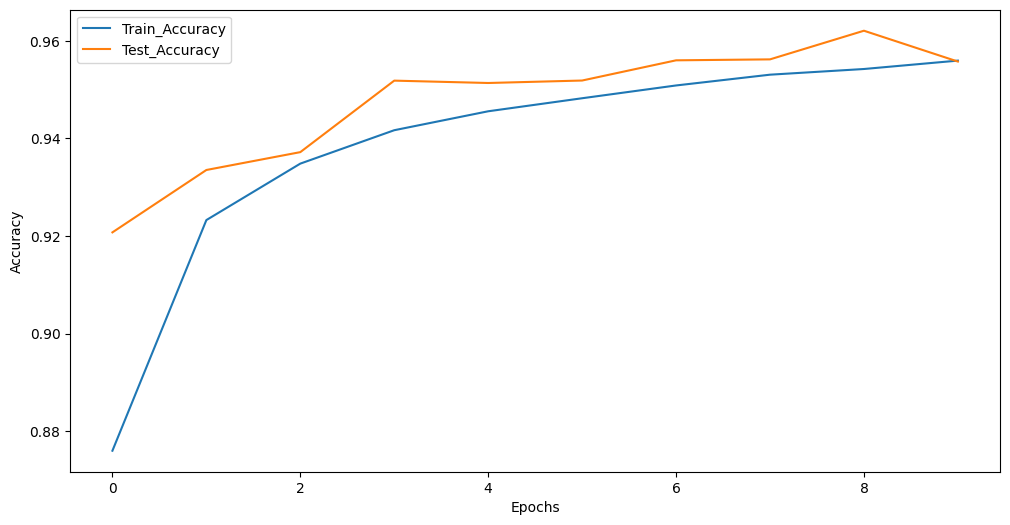

In [37]:
hist = pd.DataFrame(history.history)

plt.figure(figsize = (12, 6))
plt.plot(range(len(hist['accuracy'].values.tolist())), hist['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(hist['val_accuracy'].values.tolist())), hist['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

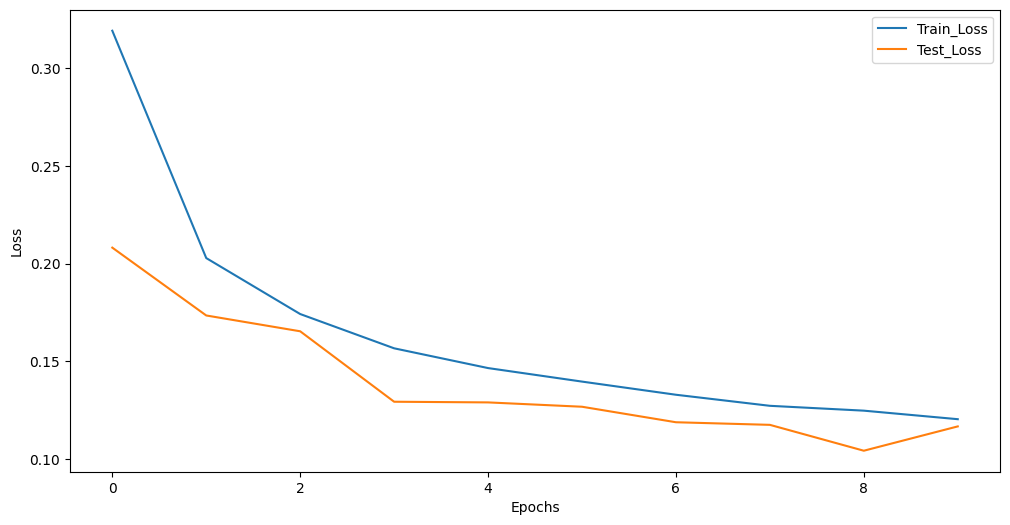

In [38]:
plt.figure(figsize = (12, 6))
plt.plot(range(len(hist['loss'].values.tolist())), hist['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(hist['val_loss'].values.tolist())), hist['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6948/6948 [==============================] - 77s 11ms/step


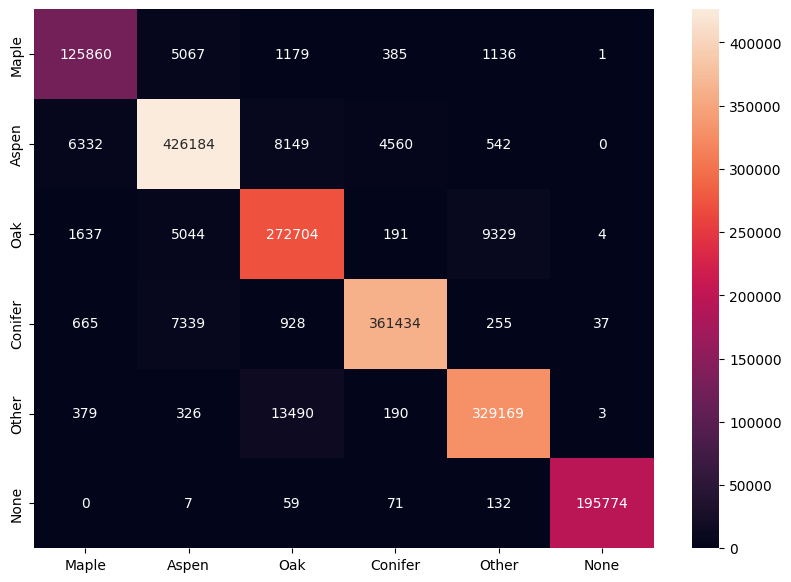

In [39]:
pred = model.predict(X_test, batch_size=256, verbose=1)

plt.figure(figsize = (10,7))

classes = ['Maple', 'Aspen', 'Oak', 'Conifer', 'Other', 'None']

mat = confusion_matrix(np.argmax(y_test, 1),
                            np.argmax(pred, 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

Each of the precision, recall, and overall accuracy for each class is over 90%.

In [40]:
# Classification Report
print(classification_report(np.argmax(y_test, 1),
                            np.argmax(pred, 1),
      target_names = ['Maple', 'Aspen', 'Oak', 'Conifer', 'Other', 'None']))

              precision    recall  f1-score   support

       Maple       0.93      0.94      0.94    133628
       Aspen       0.96      0.96      0.96    445767
         Oak       0.92      0.94      0.93    288909
     Conifer       0.99      0.98      0.98    370658
       Other       0.97      0.96      0.96    343557
        None       1.00      1.00      1.00    196043

    accuracy                           0.96   1778562
   macro avg       0.96      0.96      0.96   1778562
weighted avg       0.96      0.96      0.96   1778562



## Further Testing

To further test the performance of this model, three more images were labeled. One was taken in June, one in July, one in August. As none of these images were used for training, the performance detailed below reflects how well the model may perform when scaled up to segmenting every image in the dataset.

### Image 4

In [ ]:
im4 = plt.imread('im4\m_4111157_se_12_1_20160627.tif')

# Move band channel to first dimension for compatibility with EarthPy
im4 = np.moveaxis(im4, 2, 0)

ep.plot_rgb(
    im4,
    rgb=(0, 1, 2),
    figsize=(12, 16),
    title="RGB Composite Image of Area to Be Tested",
)

plt.show()

This first image was the only June image found with Aspen trees, but often the forests were very mixed and difficult to label, so labeling is sparse.

In [ ]:
y_data = create_gt_im(im4, '4')
seg_viz(y_data,'Ground Truth (Partial)')

In [43]:
# Move band channel to 3rd dimension and read in ground truth image
X_data = np.moveaxis(im4, 0, -1)
y_data = loadmat('im4/gt4.mat')['gt']

# Create 3D Patches
X, y = createImageCubes(X_data, y_data, windowSize=windowSize)
print(f'Patch size: {X.shape}, Labels size: {y.shape}')

sX = X[y != 0]
sy = y[y != 0]

sy = to_categorical(sy)
sy = sy[:,1:7]
sy.shape

Patch size: (45381388, 7, 7, 4), Labels size: (45381388,)


(30590, 6)

120/120 [==============================] - 2s 11ms/step


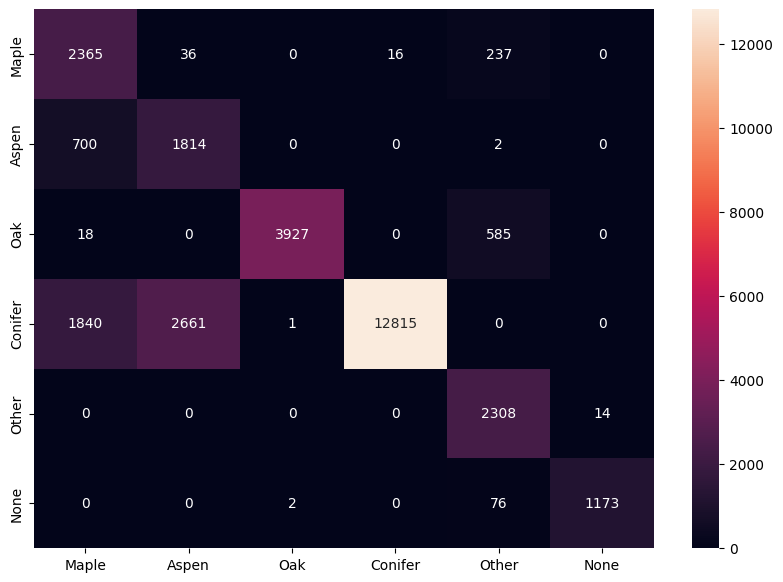

In [44]:
pred_test = model.predict(sX.reshape(-1, windowSize, windowSize, K, 1), batch_size=256, verbose=1)

plt.figure(figsize = (10,7))

classes = ['Maple', 'Aspen', 'Oak', 'Conifer', 'Other', 'None']

mat = confusion_matrix(np.argmax(sy, 1),
                            np.argmax(pred_test, 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

Segmentation of this image is 80% accurate. Maple and aspen precision is low, partly due to the disparity in the amount of labeled data between these classes and conifers.

In [45]:
# Classification Report
print(classification_report(np.argmax(sy, 1),
                            np.argmax(pred_test, 1),
      target_names = ['Maple', 'Aspen', 'Oak', 'Conifer', 'Other', 'None']))

              precision    recall  f1-score   support

       Maple       0.48      0.89      0.62      2654
       Aspen       0.40      0.72      0.52      2516
         Oak       1.00      0.87      0.93      4530
     Conifer       1.00      0.74      0.85     17317
       Other       0.72      0.99      0.83      2322
        None       0.99      0.94      0.96      1251

    accuracy                           0.80     30590
   macro avg       0.76      0.86      0.79     30590
weighted avg       0.88      0.80      0.82     30590



Now the full prediction for this image is made.

In [46]:
pred_t = model.predict(X.reshape(-1, windowSize, windowSize, K, 1),
                       batch_size=10000, verbose=1)

4539/4539 [==============================] - 435s 96ms/step


The visualization below provides additional insight. These predictions are meant to cover the mountain areas only. All the predictions to the left of the foothills can be ignored, as there are dozens, of species of trees planted in the residential areas, and the trees lining the rivers and streams are likely not any of those labeled. The predictions in the mountains and hills, upon manual comparison with the input image, seem fairly accurate, though there may be greater issues not fully captured in the classification report with maples being misclassified as aspens at the lower elevations.

In [ ]:
pred_data = np.argmax(pred_t, axis=1).reshape(im4.shape[1], im4.shape[2])
seg_viz(pred_data+1, "Segmentation Prediction", size=(20,25))

### Image 5

In [ ]:
im5 = plt.imread('im5\m_4011160_sw_12_1_20160819.tif')

# Move band channel to first dimension for compatibility with EarthPy
im5 = np.moveaxis(im5, 2, 0)

ep.plot_rgb(
    im5,
    rgb=(0, 1, 2),
    figsize=(12, 16),
    title="RGB Composite Image of Area to Be Tested",
)

plt.show()

In [ ]:
y_data = create_gt_im(im5, '5')
seg_viz(y_data,'Ground Truth (Partial)')

In [50]:
# Move band channel to 3rd dimension and read in ground truth image
X_data = np.moveaxis(im5, 0, -1)
y_data = loadmat('im5/gt5.mat')['gt']

# Create 3D Patches
X, y = createImageCubes(X_data, y_data, windowSize=windowSize)
print(f'Patch size: {X.shape}, Labels size: {y.shape}')

sX = X[y != 0]
sy = y[y != 0]

sy = to_categorical(sy)
sy = sy[:,1:7]
sy.shape

Patch size: (45648784, 7, 7, 4), Labels size: (45648784,)


(255395, 6)

998/998 [==============================] - 13s 13ms/step


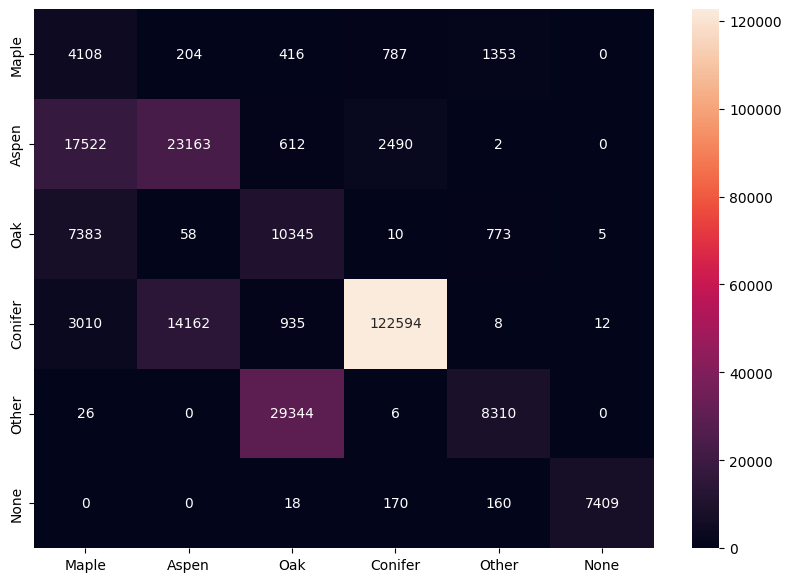

In [51]:
pred_test = model.predict(sX.reshape(-1, windowSize, windowSize, K, 1), batch_size=256, verbose=1)

plt.figure(figsize = (10,7))

classes = ['Maple', 'Aspen', 'Oak', 'Conifer', 'Other', 'None']

mat = confusion_matrix(np.argmax(sy, 1),
                            np.argmax(pred_test, 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

For this image, though generally predicted correctly, it seems there is a significant issue with aspens being labeled as maples, and other being labeled as oak. Some extra time labeling the original images may solve these issues.

In [52]:
# Classification Report
print(classification_report(np.argmax(sy, 1),
                            np.argmax(pred_test, 1),
      target_names = ['Maple', 'Aspen', 'Oak', 'Conifer', 'Other', 'None']))

              precision    recall  f1-score   support

       Maple       0.13      0.60      0.21      6868
       Aspen       0.62      0.53      0.57     43789
         Oak       0.25      0.56      0.34     18574
     Conifer       0.97      0.87      0.92    140721
       Other       0.78      0.22      0.34     37686
        None       1.00      0.96      0.98      7757

    accuracy                           0.69    255395
   macro avg       0.62      0.62      0.56    255395
weighted avg       0.81      0.69      0.72    255395



In [53]:
pred_t = model.predict(X.reshape(-1, windowSize, windowSize, K, 1),
                       batch_size=10000, verbose=1)

4565/4565 [==============================] - 443s 97ms/step


In [ ]:
pred_data = np.argmax(pred_t, axis=1).reshape(im5.shape[1], im5.shape[2])
seg_viz(pred_data+1, "Segmentation Prediction", size=(20,25))

### Image 6

In [ ]:
im6 = plt.imread('im6\m_3911112_sw_12_1_20160711.tif')

# Move band channel to first dimension for compatibility with EarthPy
im6 = np.moveaxis(im6, 2, 0)
ep.plot_rgb(
    im6,
    rgb=(0, 1, 2),
    figsize=(12, 16),
    title="RGB Composite Image of Area to Be Tested",
)

plt.show()

In [ ]:
y_data = create_gt_im(im6, '6')
seg_viz(y_data,'Ground Truth (Partial)')

In [57]:
# Move band channel to 3rd dimension and read in ground truth image
X_data = np.moveaxis(im6, 0, -1)
y_data = loadmat('im6/gt6.mat')['gt']

# Create 3D Patches
X, y = createImageCubes(X_data, y_data, windowSize=windowSize)
print(f'Patch size: {X.shape}, Labels size: {y.shape}')

sX = X[y != 0]
sy = y[y != 0]

sy = to_categorical(sy)
sy = sy[:,1:7]
sy.shape

Patch size: (45739960, 7, 7, 4), Labels size: (45739960,)


(373216, 6)

1458/1458 [==============================] - 23s 15ms/step


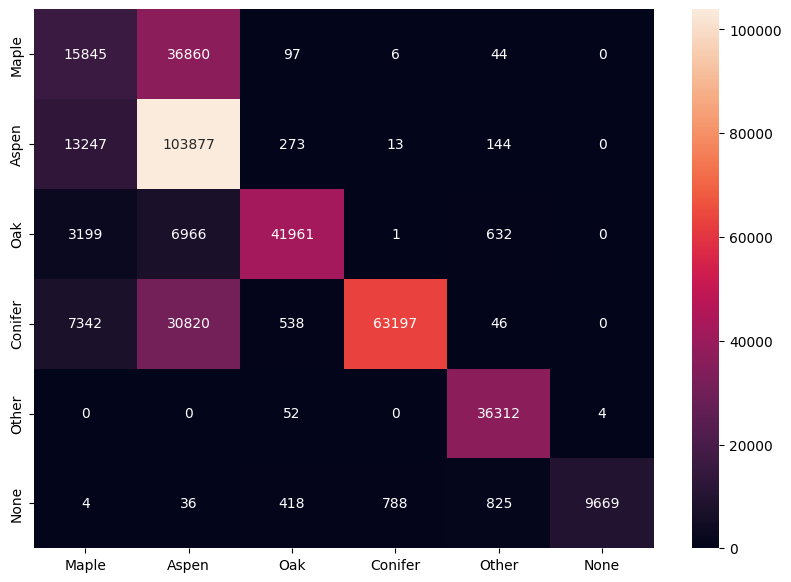

In [58]:
pred_test = model.predict(sX.reshape(-1, windowSize, windowSize, K, 1), batch_size=256, verbose=1)

plt.figure(figsize = (10,7))

classes = ['Maple', 'Aspen', 'Oak', 'Conifer', 'Other', 'None']

mat = confusion_matrix(np.argmax(sy, 1),
                            np.argmax(pred_test, 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

Overall, it's 73% accurate for the labeled data in this image. There are again some issues with maples being misclassified as aspens and conifers as aspens, but generally the labeled data is identified correctly. Labeling more maples for training would likely really improve prediction for them.

In [59]:
# Classification Report
print(classification_report(np.argmax(sy, 1),
                            np.argmax(pred_test, 1),
      target_names = ['Maple', 'Aspen', 'Oak', 'Conifer', 'Other', 'None']))

              precision    recall  f1-score   support

       Maple       0.40      0.30      0.34     52852
       Aspen       0.58      0.88      0.70    117554
         Oak       0.97      0.80      0.87     52759
     Conifer       0.99      0.62      0.76    101943
       Other       0.96      1.00      0.98     36368
        None       1.00      0.82      0.90     11740

    accuracy                           0.73    373216
   macro avg       0.82      0.74      0.76    373216
weighted avg       0.77      0.73      0.72    373216



In [60]:
pred_t = model.predict(X.reshape(-1, windowSize, windowSize, K, 1),
                       batch_size=10000, verbose=1)

4574/4574 [==============================] - 451s 97ms/step


In [ ]:
pred_data = np.argmax(pred_t, axis=1).reshape(im6.shape[1], im6.shape[2])
seg_viz(pred_data+1, "Segmentation Prediction", size=(20,25))

### Acknowledgments

3D Cube Patch Code:

M. Ahmad, A. M. Khan, M. Mazzara, S. Distefano, M. Ali and M. S. Sarfraz, "A Fast and Compact 3-D CNN for Hyperspectral Image Classification," in IEEE Geoscience and Remote Sensing Letters, vol. 19, pp. 1-5, 2022, Art no. 5502205, doi: 10.1109/LGRS.2020.3043710.

https://github.com/mahmad00/A-Fast-and-Compact-3-D-CNN-for-HSIC/blob/master/A_Fast_3D_CNN_for_HSIC_v2.ipynb

Syam Kakarla on Github:

https://gist.github.com/syamkakarla98/c76733c48d739a17c1d638450be06f4e